
# Connect Intensive - Machine Learning Nanodegree
# Lesson 3: Titanic Survival Decision Tree Mini-project 


## Objectives
  - Perform exploratory data analysis on a data set to determine relevant features to include in a model.
  - Tidy a data set so that all features will be compatible with [the `sklearn` library](http://scikit-learn.org/stable/).
      - Change categorical (object) variables to numeric with either [`pandas.Series.map()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) or [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
      - Impute missing or null values with [label-based indexing (`loc`)](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html)
  - Save cleaned datasets (so that we don't lose our hard preprocessing work!)
  - Use the `sklearn` library to build a predictive `DecisionTreeClassifier` model for the Titanic Survival Dataset.
  - Compute the accuracy of a model on both the training and validation (testing) data.
  - Adjust hyperparameters (e.g. `max_depth`) to see the effects on model accuracy.
  
## Prerequisites
  - You should have the following python packages installed:
    - [matplotlib](http://matplotlib.org/index.html)
    - [numpy](http://www.scipy.org/scipylib/download.html)
    - [pandas](http://pandas.pydata.org/getpandas.html)
    - [sklearn](http://scikit-learn.org/stable/install.html)


## Acknowledgements
  - This lesson is adapted from one of Nick Hoh's excellent [sessions](https://github.com/nickypie/ConnectIntensive). 

## Import libraries 

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
import sklearn
skversion = int(sklearn.__version__[2:4])
skversion

18

## Read the Titanic passenger data into a pandas DataFrame 

In [3]:
train_df = pd.read_csv("titanic_data.csv")

## Explore the data 

In [4]:
display(train_df.head(1))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


## Two methods for transforming to numeric features: `pandas.Series.map()` and `pandas.get_dummies()`


## [pandas.Series.map()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) 

- Takes a Python dictionary as a parameter or argument.  
- Keys of the dictionary are the current entries in the `Series` object.
- Values of the dictionary are the new desired entries for the `Series` object. 

Example: `'Sex'` feature. Map the two genders, `'female'` and `'male'`, to numbers, e.g. 0 and 1.



Run the cell below to use `Series.map()` to map the genders `'female'` and `'male'` to 0 and 1, respectively, then display the first few rows of the `DataFrame` object, and the `dtype`, to show that the `'Sex'` feature is now numeric

In [5]:
train_df['Sex'] = train_df['Sex'].map( {'female': 0, 'male': 1, 0:0, 1:1} )
display(train_df.head(2))
display(train_df['Sex'].dtype)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C


dtype('int64')

## [pandas.get dummies()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)

For the `'Embarked'` feature, which has 3 distinct categories, we use pandas.get dummies() 

Embarked categories: 

C: Cherbourg
Q: Queenstown
S: Southampton 

- Using dictionary and `Series.map()` for`'Embarked'` feature imparts some ordinality (or ordering) to the feature.

- Not logical for Cherbourg < Queenstown < Southampton 

- With 3 or more distinct but unordered categories, it is better to use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) 

- [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)turns the original feature into dummy variables (AKA indicator variables).

For more information regarding one-hot encoding, you can check out [this Quora post](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science).


**Run** the cell below to see what the dummy variables for the `Series` object `train_df['Embarked']` look like!

In [6]:
train_dummies = pd.get_dummies(train_df['Embarked'])
display(train_dummies.head())

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


## Renaming the features

**Run** the cell below to rename the features to the full name of the port of embarkation using the method pandas.DataFrame.rename():

In [7]:
train_dummies = train_dummies.rename(columns={'C':'Cherbourg','Q':'Queenstown','S':'Southampton'})
display(train_dummies.head())

,Cherbourg,Queenstown,Southampton
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


## Combine train_dummies and train_df

**Run** the cell below to concatenate (combine) `train_df` and `train_dummies` and print the result. Note, the `if` statement ensures that we don't concatenate the dummies more than once if you run the cell multiple times.

In [8]:
if 'Cherbourg' not in list(train_df.columns):
    train_df = pd.concat([train_df, train_dummies], axis=1)
display(train_df.head(2))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cherbourg,Queenstown,Southampton
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0


## Impute missing or null values 


Run the cell below to compute the mean of the `Series` object `train_df['Age']` and properly impute the missing 'Age' values.

- Recall that loc is label-based indexing, while iloc is integer-based indexing. 
- Our row_indexer is the boolean Series object train_df['Age'].isnull(). 
- Our column_indexer is simply the label-based index 'Age'.

Note that the default behavior for [the method `pandas.Series.mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.mean.html) is to skip null values, so setting the parameter `skipna=True` isn't necessary.

In [9]:
display(train_df.info())
mean_age = train_df['Age'].mean(skipna=True)
print("mean age: {:.1f}".format(mean_age))

train_df.loc[train_df['Age'].isnull(),'Age'] = mean_age
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Cherbourg      891 non-null uint8
Queenstown     891 non-null uint8
Southampton    891 non-null uint8
dtypes: float64(2), int64(6), object(4), uint8(3)
memory usage: 86.2+ KB


None

mean age: 29.7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Cherbourg      891 non-null uint8
Queenstown     891 non-null uint8
Southampton    891 non-null uint8
dtypes: float64(2), int64(6), object(4), uint8(3)
memory usage: 86.2+ KB


None

## Save the preprocessed data

Run the cell below to write the titanic DataFrame object to a csv file using the method pandas.DataFrame.to_csv(). Note, from the module os.path we import the method isfile, which allows us to check whether the file already has been saved.

In [10]:
from os.path import isfile
titanic_data_clean = "titanic_data_clean.csv"
if not isfile(titanic_data_clean):
    train_df.to_csv(titanic_data_clean)
    print("Cleaned Titanic dataset saved!")
else:
    print("Cleaned Titanic dataset already saved!")

Cleaned Titanic dataset saved!


## Load the preprocessed data 

In [11]:
train_df = pd.read_csv("titanic_data_clean.csv")

## Using `train_test_split`

  - **Training set:** A set of examples used for machine learning, that is to fit the parameters (*i.e.*, weights) of the classifier.
  - **Validation set:** A set of examples used to tune the hyperparameters (*i.e.*, architecture, not weights) of a classifier, for example to choose the maximum depth of a decision tree, or the number of hidden layers in a neural network.
  - **Test set:** A set of examples used only *once*. This assesses the performance (generalization) of the fully-specified classifier (once all hyperparameters have been specified).


**Run** the cell below to create the `DataFrame` object `X` and the `Series` object `y` from the desired features from `train_df`. Then use `train_test_split()` with a `random_state` to split the dataset.

In [46]:
# Starting with scikit-learn version 0.18, the model_selection module replaces the cross_validation module,
# so we should import train_test_split from the appropriate module depending on the version number.

if skversion >= 18:
    from sklearn.model_selection import train_test_split
else:
    from sklearn.cross_validation import train_test_split

# Make a list of the desired feature names for model building
desired_features = ['Pclass', 'Sex', 'Age','SibSp','Parch', 'Cherbourg','Queenstown','Southampton']

# X is our pandas DataFrame object with the features from which we will predict the 'Survived' feature.
X = pd.DataFrame(train_df[desired_features])

# y is our pandas Series object with the 'Survived' feature to be predicted.
y = pd.Series(train_df['Survived'])

# Split the data into training and validation (test) data sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Take a look at the first few rows of the training features and classes
display(X_train.head())
display(y_train.head())

# Verify that the data sets were split 80% training and 20% testing
print("The original data ({} instances) was split into training ({} instances) and testing ({} instances) data sets".\
     format(len(X),len(X_train),len(X_test)))

,Pclass,Sex,Age,SibSp,Parch,Cherbourg,Queenstown,Southampton
146,3,1,27.0,0,0,0,0,1
195,1,0,58.0,0,0,1,0,0
786,3,0,18.0,0,0,0,0,1
290,1,0,26.0,0,0,0,0,1
521,3,1,22.0,0,0,0,0,1


146    1
195    1
786    1
290    1
521    0
Name: Survived, dtype: int64

The original data (891 instances) was split into training (712 instances) and testing (179 instances) data sets


## Building a Decision Tree Classifier
For supervised learning problems, the model building `sklearn` workflow is pretty similar, regardless of the type of classifier you'd like to build:
  1. **Create** a classifier object.
  2. **Train** the classifier on the training data set.
  3. **Predict** with the classifier on the validation (test) data set.
  4. **Assess** the accuracy of the classifier, comparing the predictions to the actual labels.

Run the cell below to **create** a Decision Tree Classifier, **train** it on the training data, **predict** class labels for the validation (test) data set, and **assess** the accuracy of the classifier.

In [47]:
# Import DecisionTreeClassifier and accuracy_score 
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import accuracy_score

# 1. CREATE the classifier object.
clf = DecisionTreeClassifier(criterion='gini',random_state=0, max_depth=5)

# 2. TRAIN the classifier object using the method .fit()
clf.fit(X_train, y_train)

# 3. PREDICT labels for the validation test set using the method .predict()
y_pred_train = clf.predict(X_train)
y_pred_test  = clf.predict(X_test)

# 4. ASSESS the accuracy of the classifier, comparing the predictions to the actual labels.
print("The model with max_depth of {} has an accuracy of {:.1f}% on the training data, and {:.1f}% on the testing data".\
      format(1,\
             100.0*accuracy_score(y_pred_train,y_train),\
             100.0*accuracy_score(y_pred_test, y_test)))

The model with max_depth of 1 has an accuracy of 85.8% on the training data, and 82.1% on the testing data


In [48]:
clf.feature_importances_

array([ 0.21872717,  0.52018968,  0.12760484,  0.07097604,  0.01227039,
        0.0129715 ,  0.        ,  0.03726039])

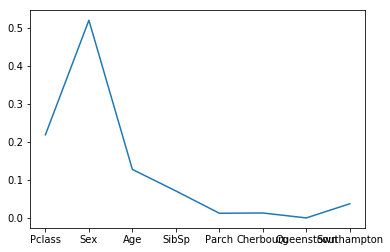

In [49]:
import matplotlib.pyplot as plt
x=np.arange(1,len(clf.feature_importances_)+1,1)
plt.xticks(x, desired_features)
plt.plot(x, clf.feature_importances_)
plt.show()

In [50]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [53]:
visualize_tree(clf, desired_features)

In [54]:
dot -Tpng dt.dot -o tree.png 

SyntaxError: invalid syntax (<ipython-input-54-1111d31b5d0c>, line 1)